This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Load ODIM_H5 Volume data from German Weather Service

In this example, we obtain and read the latest 30 minutes of available volumetric radar data from German Weather Service available at [opendata.dwd.de](https://opendata.dwd.de). Finally we do some plotting.

This retrieves 6 timesteps of the 10 sweeps (moments DBZH and VRADH) of the DWD volume scan of a distinct radar. This amounts to 120 data files which are combined into one volumetric Cf/Radial2 like xarray powered structure.

Exports to single file Odim_H5 and Cf/Radial2 format are shown at the end of this tutorial.

<div class="alert alert-warning">

**Note** <br>

The following code is based on [xarray](https://docs.xarray.dev), [xarray-datatree](https://xarray-datatree.readthedocs.io) and [xradar](https://docs.openradarscience.org/projects/xradar). It claims multiple data files and presents them in a ``DataTree``.

</div>

In [1]:
import wradlib as wrl
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xradar
from datatree import DataTree, open_datatree

try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    plt.ion()

In [2]:
import urllib3
import os
import io
import glob
import shutil
import datetime

In [3]:
from html.parser import HTMLParser


class DWDHTMLParser(HTMLParser):
    def handle_starttag(self, tag, attrs):
        if tag != "a":
            return
        self.links.append(attrs[0][1])


parser = DWDHTMLParser()

# Download data from opendata.dwd.de

In [4]:
radar = "ESS"
DBZH = "sweep_vol_z"
VRADH = "sweep_vol_v"

import certifi

opendata_url1 = f"https://opendata.dwd.de/weather/radar/sites/{DBZH}/{radar.lower()}/hdf5/filter_polarimetric/"

http = urllib3.PoolManager(cert_reqs="CERT_REQUIRED", ca_certs=certifi.where())
response = http.request("GET", opendata_url1).data.decode("utf-8")

parser.links = []
parser.feed(response)
filelist1 = parser.links[1:]

filelist1.sort(key=lambda x: x.split("-")[2])
filelist1.reverse()

opendata_url2 = f"https://opendata.dwd.de/weather/radar/sites/{VRADH}/{radar.lower()}/hdf5/filter_polarimetric/"

http = urllib3.PoolManager(cert_reqs="CERT_REQUIRED", ca_certs=certifi.where())
response = http.request("GET", opendata_url2).data.decode("utf-8")

parser.links = []
parser.feed(response)
filelist2 = parser.links[1:]

filelist2.sort(key=lambda x: x.split("-")[2])
filelist2.reverse()

## Clean up local folder

In [5]:
flist = glob.glob("ras07*")
for f in flist:
    os.remove(f)

## Download latest 24 volumes to current directory

In [6]:
for f in filelist1[: 10 * 24]:
    with http.request(
        "GET", os.path.join(opendata_url1, f), preload_content=False
    ) as r, open(f, "wb") as out:
        shutil.copyfileobj(r, out)

for f in filelist2[: 10 * 24]:
    with http.request(
        "GET", os.path.join(opendata_url2, f), preload_content=False
    ) as r, open(f, "wb") as out:
        shutil.copyfileobj(r, out)

In [7]:
volume_reflectivity = glob.glob("ras07*_dbzh_*")
volume_velocity = glob.glob("ras07*_vradh_*")

In [8]:
volume_reflectivity = np.array(
    sorted(volume_reflectivity, key=lambda x: x.split("-")[2])
)
volume_velocity = np.array(sorted(volume_velocity, key=lambda x: x.split("-")[2]))
volume_reflectivity[:15]

array(['ras07-vol5minng01_sweeph5onem_dbzh_00-2024083008055700-ess-10410-hd5',
       'ras07-vol5minng01_sweeph5onem_dbzh_01-2024083008062000-ess-10410-hd5',
       'ras07-vol5minng01_sweeph5onem_dbzh_02-2024083008064300-ess-10410-hd5',
       'ras07-vol5minng01_sweeph5onem_dbzh_03-2024083008070600-ess-10410-hd5',
       'ras07-vol5minng01_sweeph5onem_dbzh_04-2024083008072900-ess-10410-hd5',
       'ras07-vol5minng01_sweeph5onem_dbzh_05-2024083008080000-ess-10410-hd5',
       'ras07-vol5minng01_sweeph5onem_dbzh_06-2024083008082200-ess-10410-hd5',
       'ras07-vol5minng01_sweeph5onem_dbzh_07-2024083008083500-ess-10410-hd5',
       'ras07-vol5minng01_sweeph5onem_dbzh_08-2024083008084800-ess-10410-hd5',
       'ras07-vol5minng01_sweeph5onem_dbzh_09-2024083008090200-ess-10410-hd5',
       'ras07-vol5minng01_sweeph5onem_dbzh_00-2024083008105800-ess-10410-hd5',
       'ras07-vol5minng01_sweeph5onem_dbzh_01-2024083008112100-ess-10410-hd5',
       'ras07-vol5minng01_sweeph5onem_dbzh_02-202408

In [9]:
volume_reflectivity = volume_reflectivity.reshape(-1, 10).T
volume_velocity = volume_velocity.reshape(-1, 10).T

In [10]:
volume_reflectivity = sorted(
    volume_reflectivity, key=lambda x: x[0].split("-")[1].split("_")[-1]
)
volume_reflectivity = volume_reflectivity[5:] + volume_reflectivity[:5]
volume_velocity = sorted(
    volume_velocity, key=lambda x: x[0].split("-")[1].split("_")[-1]
)
volume_velocity = volume_velocity[5:] + volume_velocity[:5]
len(volume_reflectivity)

10

## Read the data into xarray powered structure

In [11]:
dsl = []
reindex_angle = dict(
    tolerance=1.0, start_angle=0, stop_angle=360, angle_res=1.0, direction=1
)
for r, v in zip(volume_reflectivity, volume_velocity):
    ds0 = [
        xr.open_dataset(r0, engine="odim", group="sweep_0", reindex_angle=reindex_angle)
        for r0 in r
    ]
    ds1 = [
        xr.open_dataset(v0, engine="odim", group="sweep_0", reindex_angle=reindex_angle)
        for v0 in v
    ]
    ds = xr.concat(
        [
            xr.merge([r0, v0], compat="override").assign(volume_time=r0.time.min())
            for r0, v0 in zip(ds0, ds1)
        ],
        "volume_time",
    )
    dsl.append(ds)

dsl.insert(0, xr.open_dataset(volume_reflectivity[0][0], group="/"))

In [12]:
tree = DataTree(data=xradar.io.backends.common._assign_root(dsl), name="root")
vol = xradar.io.backends.common._attach_sweep_groups(tree, dsl[1:])
for i, swp in enumerate(vol.groups[1:]):
    vol[swp]["sweep_number"] = i
# sets arbitrary volume_time in root group to enable isel over groups
vol = vol.assign_coords(volume_time=vol["sweep_0"].volume_time)

## Inspect structure
### Root Group

In [13]:
vol.root

DataTree('root', parent=None)
│   Dimensions:              (volume_time: 24)
│   Coordinates:
│       longitude            float64 8B 6.967
│       altitude             float64 8B 185.1
│       latitude             float64 8B 51.41
│     * volume_time          (volume_time) datetime64[ns] 192B 2024-08-30T08:07:3...
│   Data variables:
│       volume_number        int64 8B 0
│       platform_type        <U5 20B 'fixed'
│       instrument_type      <U5 20B 'radar'
│       time_coverage_start  <U20 80B '2024-08-30T08:05:35Z'
│       time_coverage_end    <U20 80B '2024-08-30T10:04:02Z'
│   Attributes:
│       Conventions:      ODIM_H5/V2_2
│       instrument_name:  None
│       version:          None
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None
│       comment:          im/exported using xradar
├── DataTree('sweep_0')
│       Dimensions:            (volume_time: 24, azimuth: 360, range: 720)
│       Coordinates:
│         * range              (range) float32 3kB 125.0 375.0 ... 1.796e+05 1.799e+05
│         * azimuth            (azimuth) float64 3kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
│           elevation          (volume_time, azimuth) float64 69kB 0.4834 ... 0.4834
│           time               (volume_time, azimuth) datetime64[ns] 69kB 2024-08-30T...
│           longitude          float64 8B 6.967
│           latitude           float64 8B 51.41
│           altitude           float64 8B 185.1
│         * volume_time        (volume_time) datetime64[ns] 192B 2024-08-30T08:07:30....
│       Data variables:
│           DBZH               (volume_time, azimuth, range) float64 50MB -64.0 ... -...
│           sweep_mode         (volume_time) <U20 2kB 'azimuth_surveillance' ... 'azi...
│           sweep_number       int64 8B 0
│           prt_mode           (volume_time) <U7 672B 'not_set' 'not_set' ... 'not_set'
│           follow_mode        (volume_time) <U7 672B 'not_set' 'not_set' ... 'not_set'
│           sweep_fixed_angle  (volume_time) float64 192B 0.4999 0.4999 ... 0.4999
│           VRADH              (volume_time, azimuth, range) float64 50MB -128.0 ... ...
├── DataTree('sweep_1')
│       Dimensions:            (volume_time: 24, azimuth: 360, range: 496)
│       Coordinates:
│         * range              (range) float32 2kB 125.0 375.0 ... 1.236e+05 1.239e+05
│         * azimuth            (azimuth) float64 3kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
│           elevation          (volume_time, azimuth) float64 69kB 7.987 7.987 ... 7.987
│           time               (volume_time, azimuth) datetime64[ns] 69kB 2024-08-30T...
│           longitude          float64 8B 6.967
│           latitude           float64 8B 51.41
│           altitude           float64 8B 185.1
│         * volume_time        (volume_time) datetime64[ns] 192B 2024-08-30T08:07:30....
│       Data variables:
│           DBZH               (volume_time, azimuth, range) float64 34MB -64.0 ... -...
│           sweep_mode         (volume_time) <U20 2kB 'azimuth_surveillance' ... 'azi...
│           sweep_number       int64 8B 1
│           prt_mode           (volume_time) <U7 672B 'not_set' 'not_set' ... 'not_set'
│           follow_mode        (volume_time) <U7 672B 'not_set' 'not_set' ... 'not_set'
│           sweep_fixed_angle  (volume_time) float64 192B 7.998 7.998 ... 7.998 7.998
│           VRADH              (volume_time, azimuth, range) float64 34MB -128.0 ... ...
├── DataTree('sweep_2')
│       Dimensions:            (volume_time: 24, azimuth: 360, range: 240)
│       Coordinates:
│         * range              (range) float32 960B 125.0 375.0 ... 5.962e+04 5.988e+04
│         * azimuth            (azimuth) float64 3kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
│           elevation          (volume_time, azimuth) float64 69kB 11.99 11.99 ... 12.0
│           time               (volume_time, azimuth) datetime64[ns] 69kB 2024-08-30T...
│           longitude  

### Sweep Groups

In [14]:
vol["sweep_0"]

DataTree('sweep_0', parent="root")
    Dimensions:            (volume_time: 24, azimuth: 360, range: 720)
    Coordinates:
      * range              (range) float32 3kB 125.0 375.0 ... 1.796e+05 1.799e+05
      * azimuth            (azimuth) float64 3kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
        elevation          (volume_time, azimuth) float64 69kB 0.4834 ... 0.4834
        time               (volume_time, azimuth) datetime64[ns] 69kB 2024-08-30T...
        longitude          float64 8B 6.967
        latitude           float64 8B 51.41
        altitude           float64 8B 185.1
      * volume_time        (volume_time) datetime64[ns] 192B 2024-08-30T08:07:30....
    Data variables:
        DBZH               (volume_time, azimuth, range) float64 50MB -64.0 ... -...
        sweep_mode         (volume_time) <U20 2kB 'azimuth_surveillance' ... 'azi...
        sweep_number       int64 8B 0
        prt_mode           (volume_time) <U7 672B 'not_set' 'not_set' ... 'not_set'
        follow_mode        (volume_time) <U7 672B 'not_set' 'not_set' ... 'not_set'
        sweep_fixed_angle  (volume_time) float64 192B 0.4999 0.4999 ... 0.4999
        VRADH              (volume_time, azimuth, range) float64 50MB -128.0 ... ...

## plot sweeps
### DBZH

In [15]:
vol["sweep_0"].isel(volume_time=0)

DataTree('sweep_0', parent=None)
    Dimensions:            (azimuth: 360, range: 720)
    Coordinates:
      * range              (range) float32 3kB 125.0 375.0 ... 1.796e+05 1.799e+05
      * azimuth            (azimuth) float64 3kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
        elevation          (azimuth) float64 3kB 0.4834 0.4834 ... 0.4834 0.4834
        time               (azimuth) datetime64[ns] 3kB 2024-08-30T08:07:52.52999...
        longitude          float64 8B 6.967
        latitude           float64 8B 51.41
        altitude           float64 8B 185.1
        volume_time        datetime64[ns] 8B 2024-08-30T08:07:30.775000064
    Data variables:
        DBZH               (azimuth, range) float64 2MB -64.0 -64.0 ... -64.0 -64.0
        sweep_mode         <U20 80B 'azimuth_surveillance'
        sweep_number       int64 8B 0
        prt_mode           <U7 28B 'not_set'
        follow_mode        <U7 28B 'not_set'
        sweep_fixed_angle  float64 8B 0.4999
        VRADH              (azimuth, range) float64 2MB -128.0 -128.0 ... -128.0

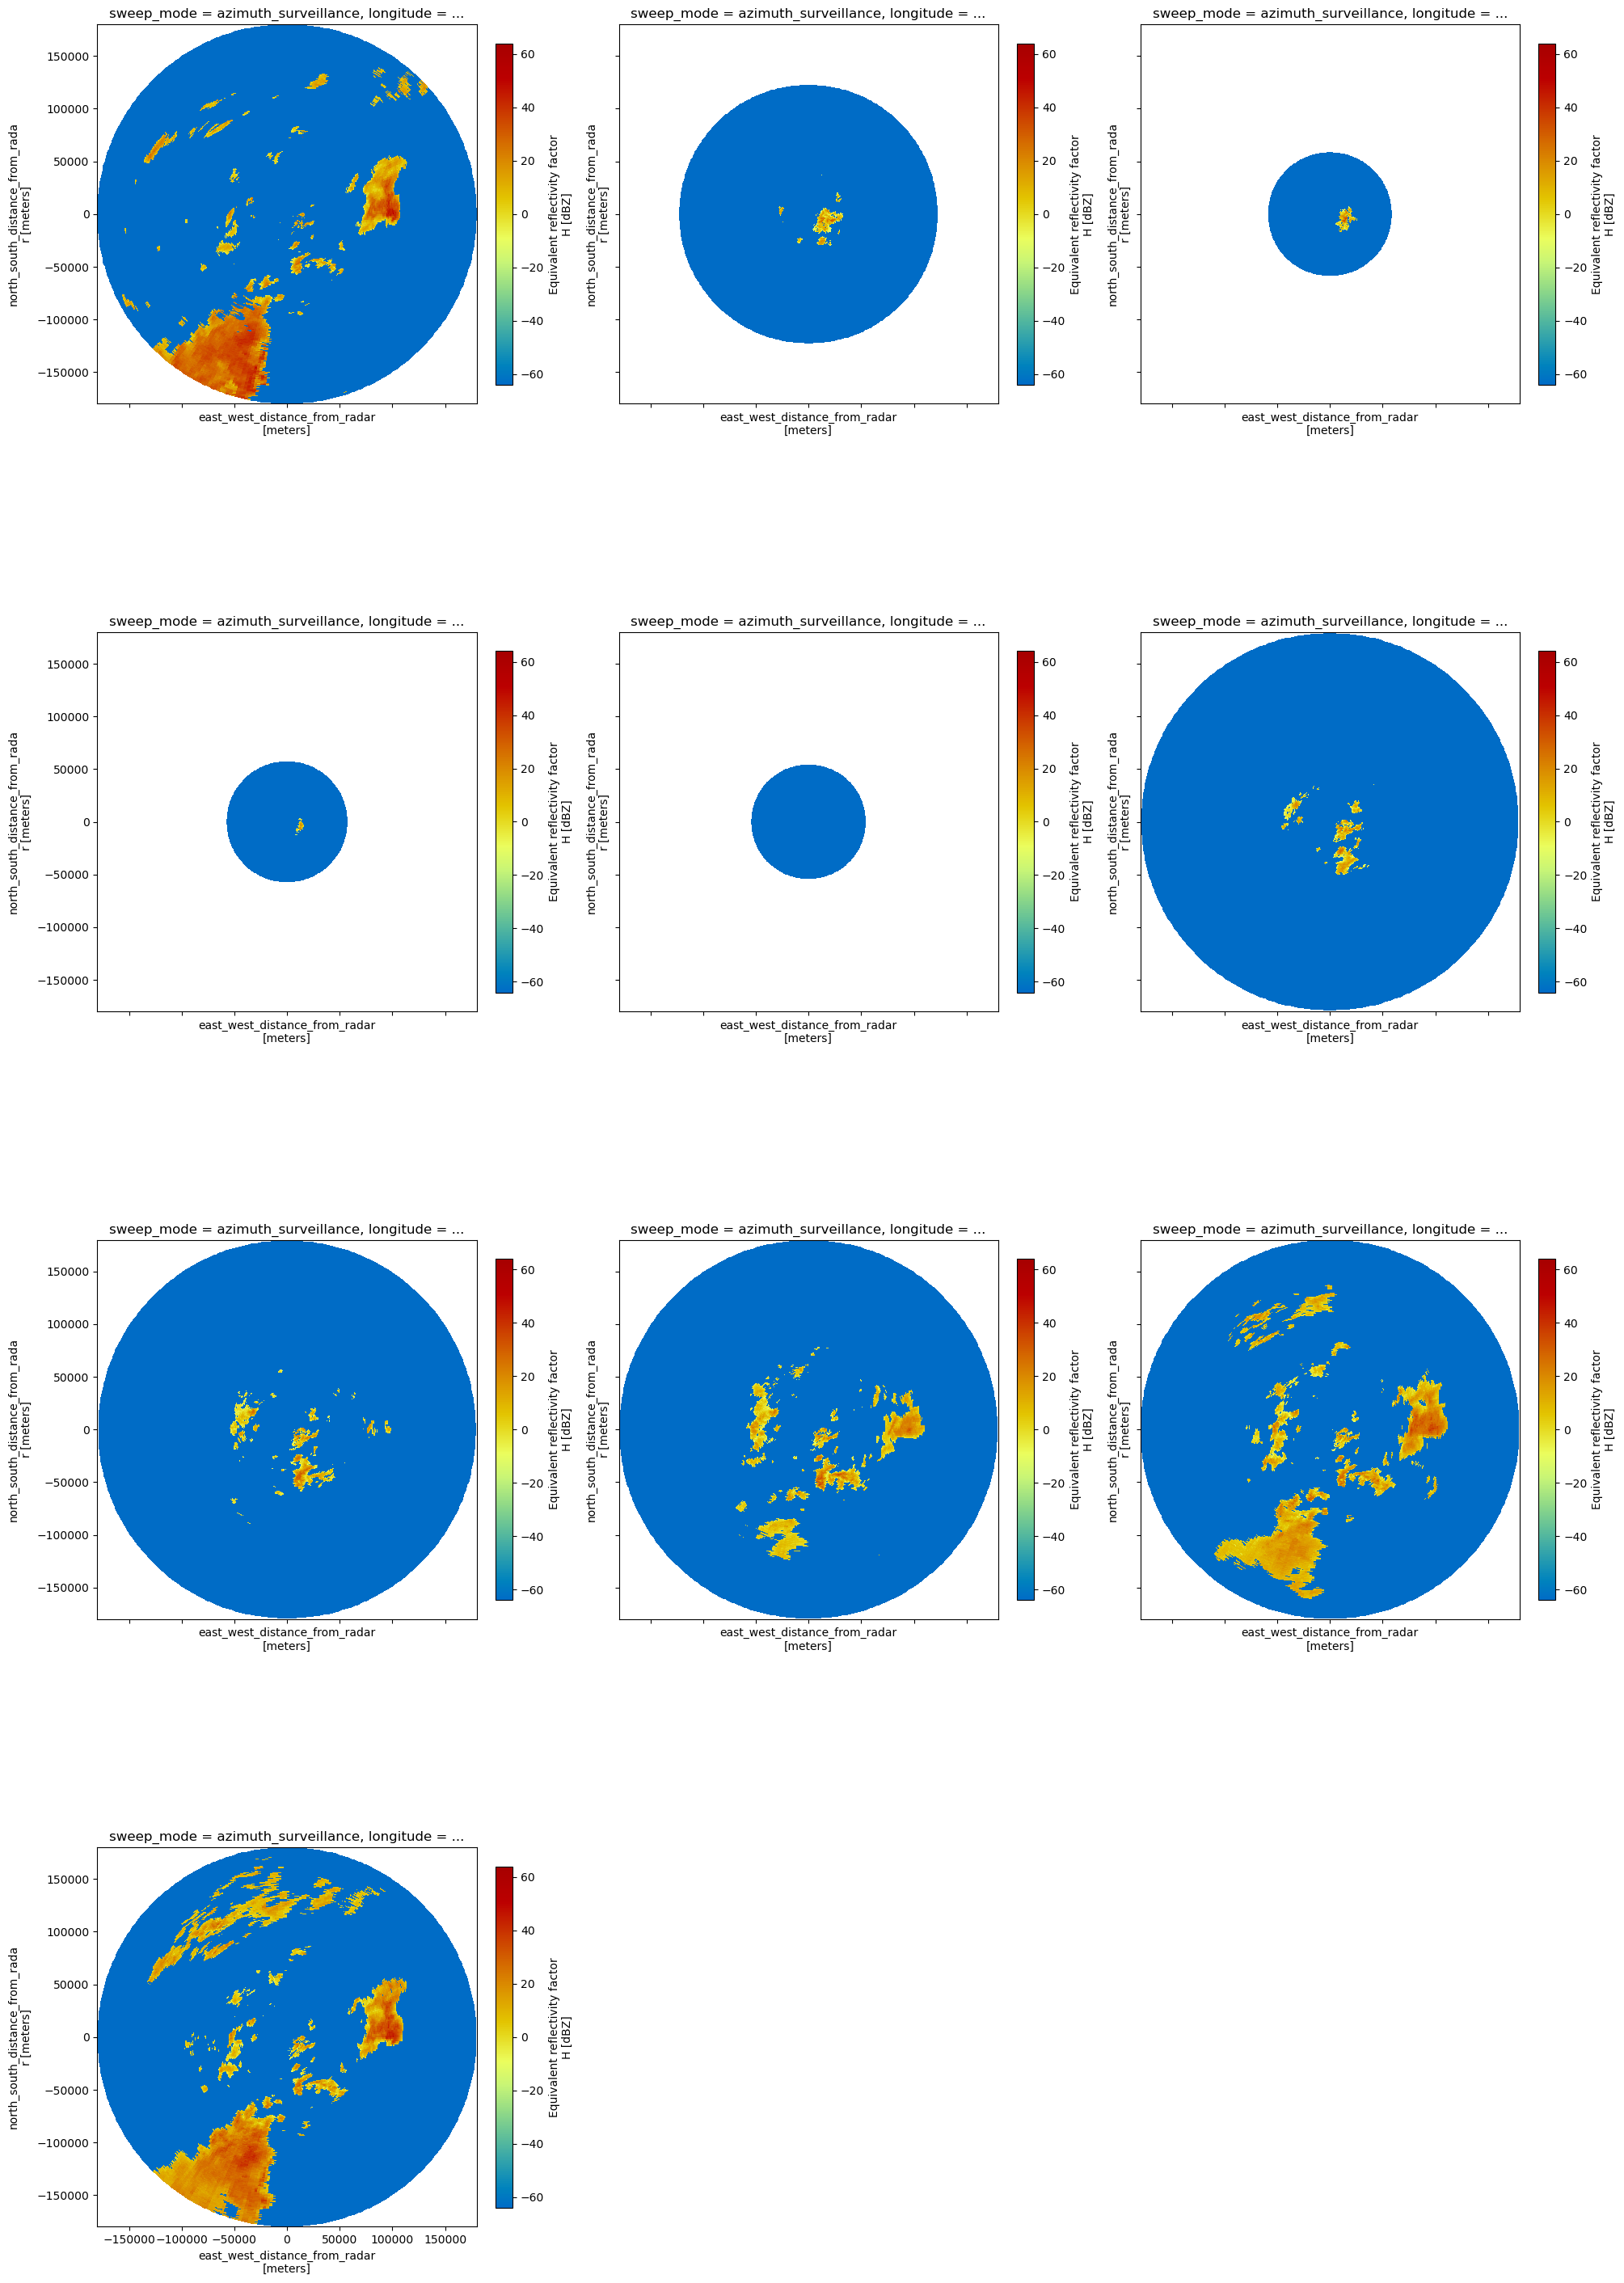

In [16]:
fig, gs = plt.subplots(
    4, 3, figsize=(20, 30), sharex=True, sharey=True, constrained_layout=True
)

for i, grp in enumerate(vol.groups[1:]):
    swp = vol[grp].isel(volume_time=0).ds
    swp = swp.assign_coords(sweep_mode=swp.sweep_mode)
    swp.DBZH.wrl.georef.georeference().wrl.vis.plot(ax=gs.flat[i], fig=fig)
    ax = plt.gca()
    ax.set_title(swp.sweep_fixed_angle.values)

fig.delaxes(gs.flat[-2])
fig.delaxes(gs.flat[-1])

### VRADH

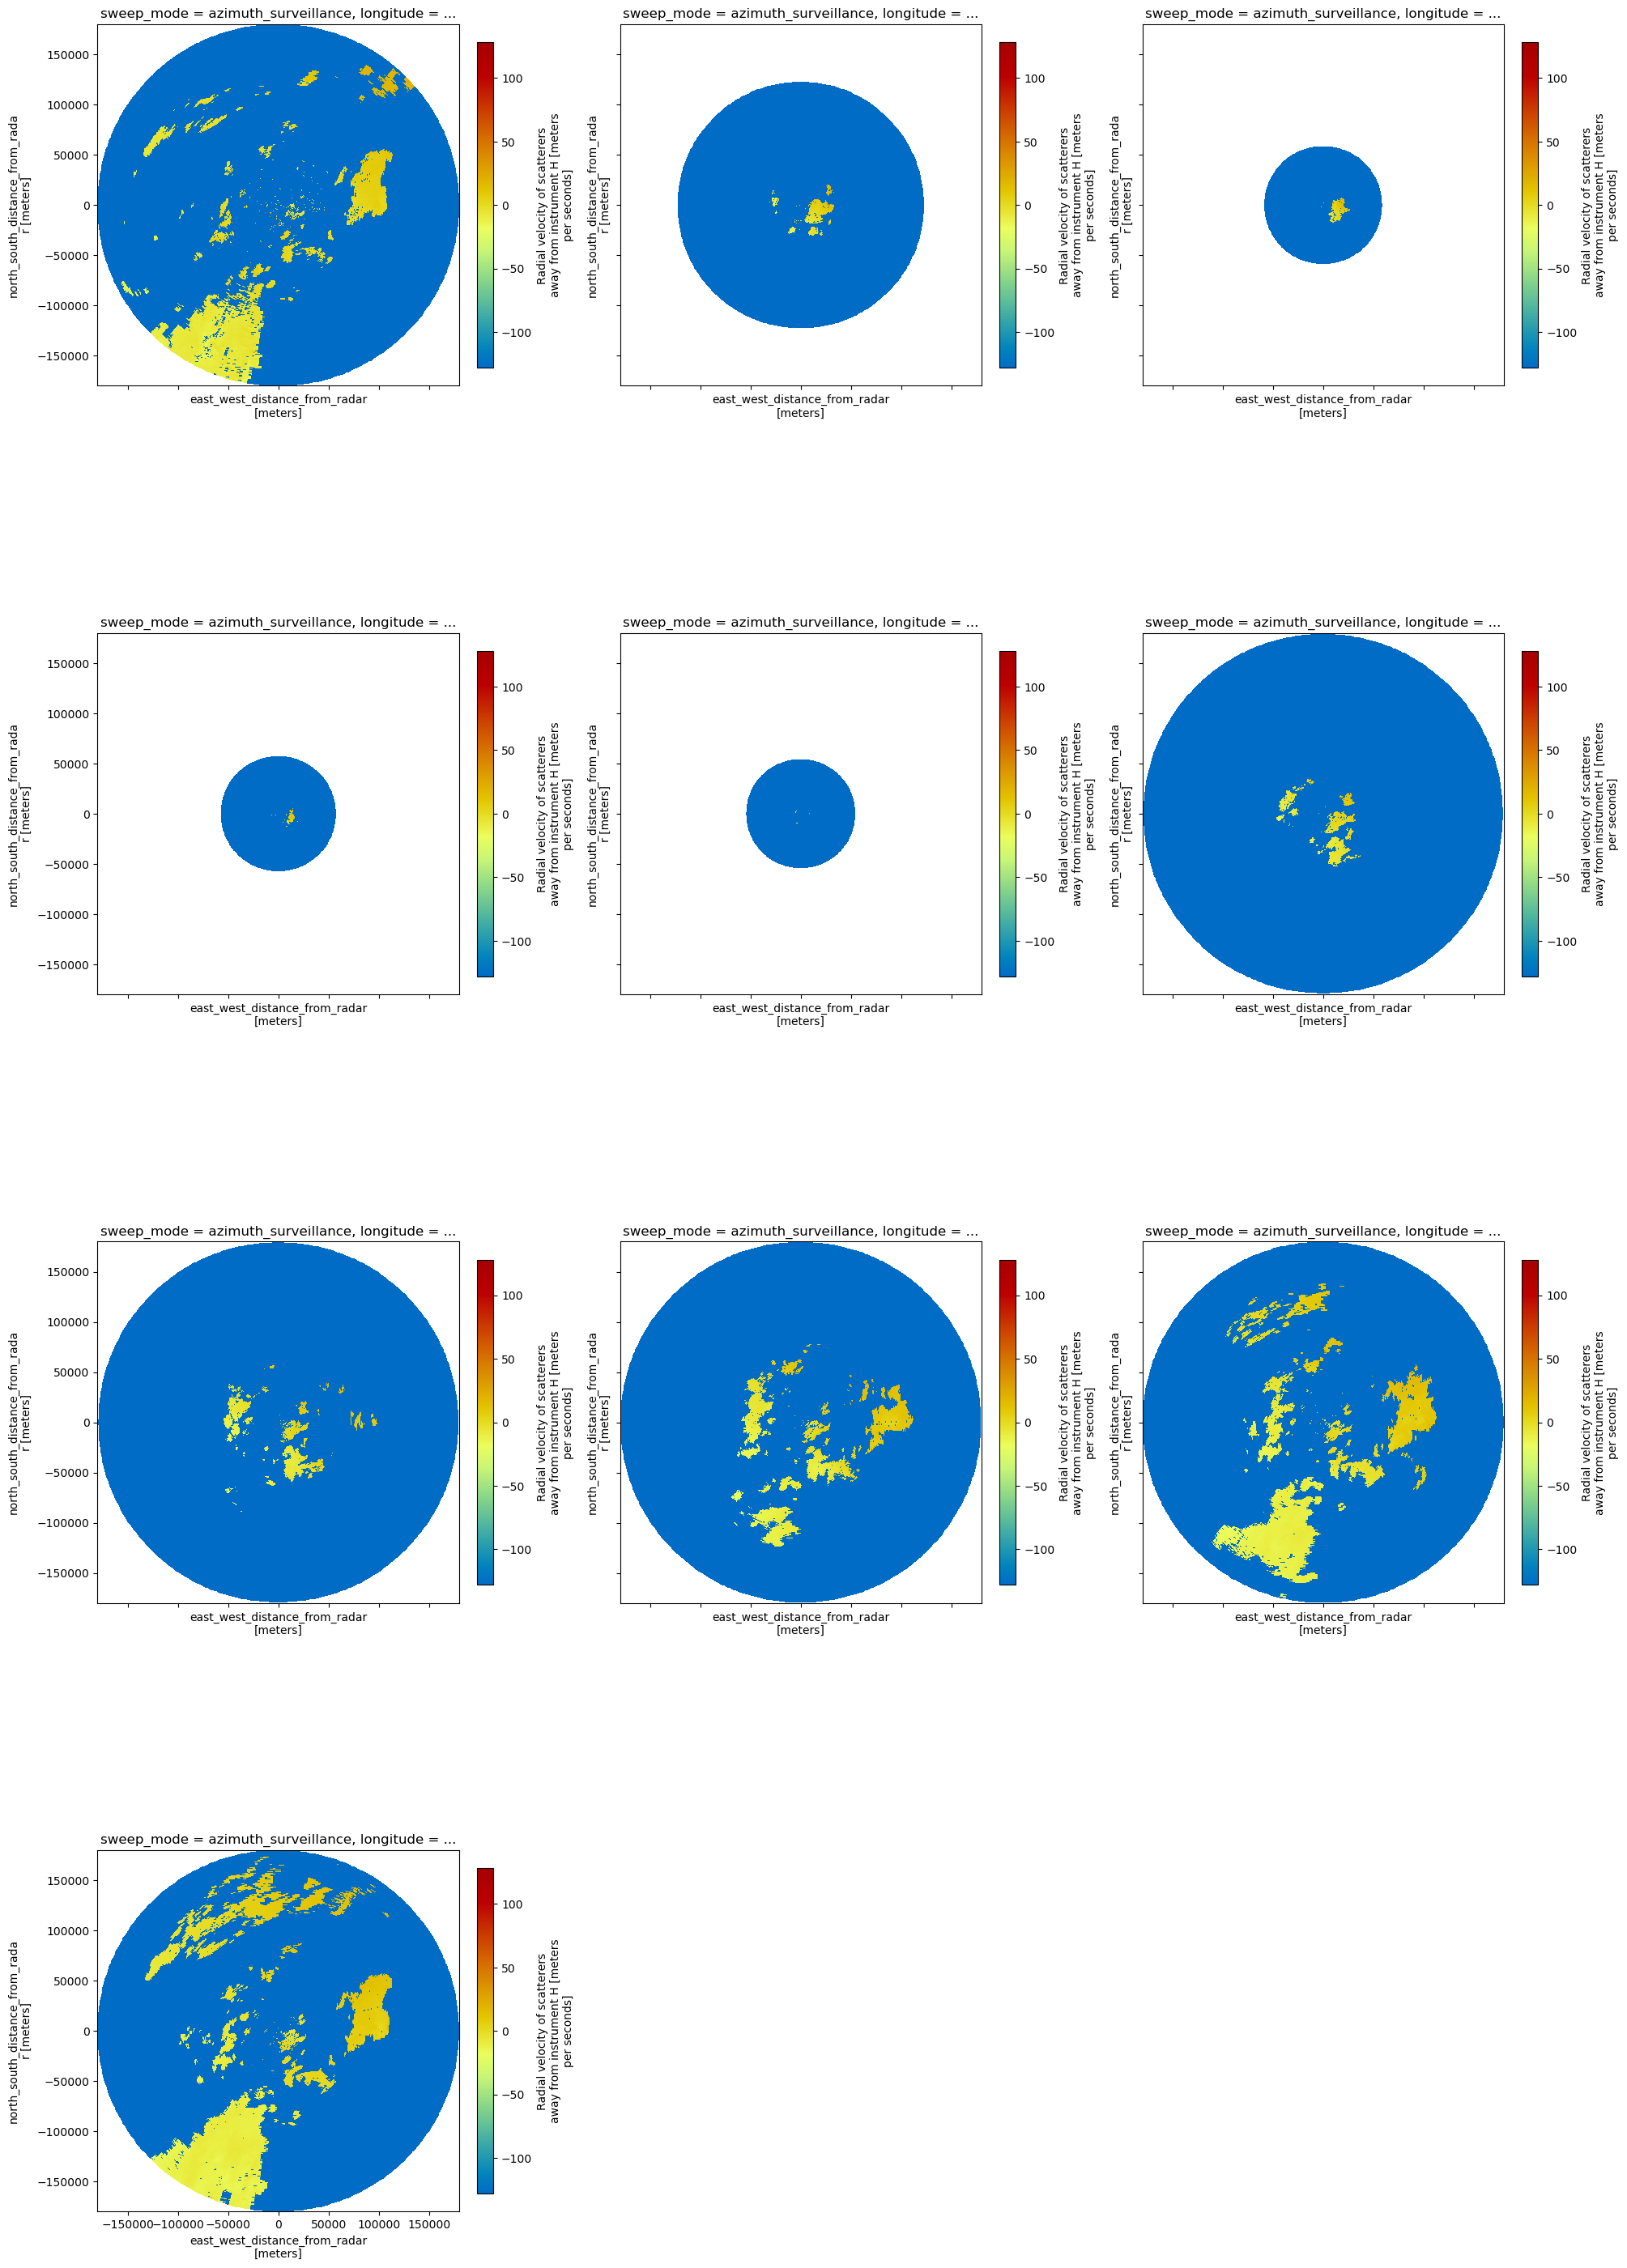

In [17]:
fig, gs = plt.subplots(
    4, 3, figsize=(20, 30), sharex=True, sharey=True, constrained_layout=True
)

for i, grp in enumerate(vol.groups[1:]):
    swp = vol[grp].isel(volume_time=0).ds
    swp = swp.assign_coords(sweep_mode=swp.sweep_mode)
    swp.VRADH.wrl.georef.georeference().wrl.vis.plot(ax=gs.flat[i], fig=fig)
    ax = plt.gca()
    ax.set_title(swp.sweep_fixed_angle.values)

fig.delaxes(gs.flat[-2])
fig.delaxes(gs.flat[-1])

### Plot single sweep using cartopy

In [18]:
vol0 = vol.isel(volume_time=0)
swp = vol0["sweep_9"].ds
# need to assign sweep_mode as coordinate
swp = swp.assign_coords(sweep_mode=swp.sweep_mode)

In [19]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

map_trans = ccrs.AzimuthalEquidistant(
    central_latitude=vol0.root.ds.latitude.values,
    central_longitude=vol0.root.ds.longitude.values,
)

< GeoAxes: +proj=aeqd +ellps=WGS84 +lon_0=6.967111 +lat_0=51.405649 +x_0=0.0 +y_0=0.0 +no_defs +type=crs >


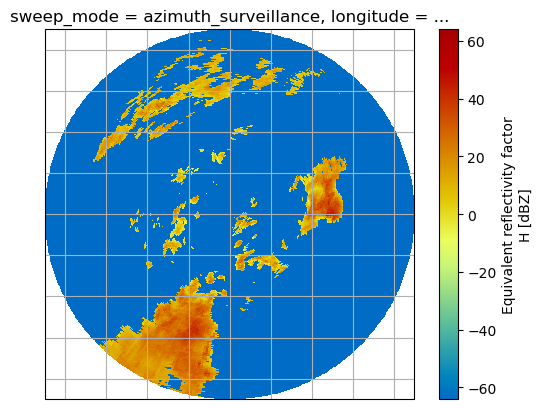

In [20]:
map_proj = ccrs.AzimuthalEquidistant(
    central_latitude=vol0.root.ds.latitude.values,
    central_longitude=vol0.root.ds.longitude.values,
)

pm = swp.DBZH.wrl.georef.georeference().wrl.vis.plot(crs=map_proj)
ax = plt.gca()
ax.gridlines(crs=map_proj)
print(ax)

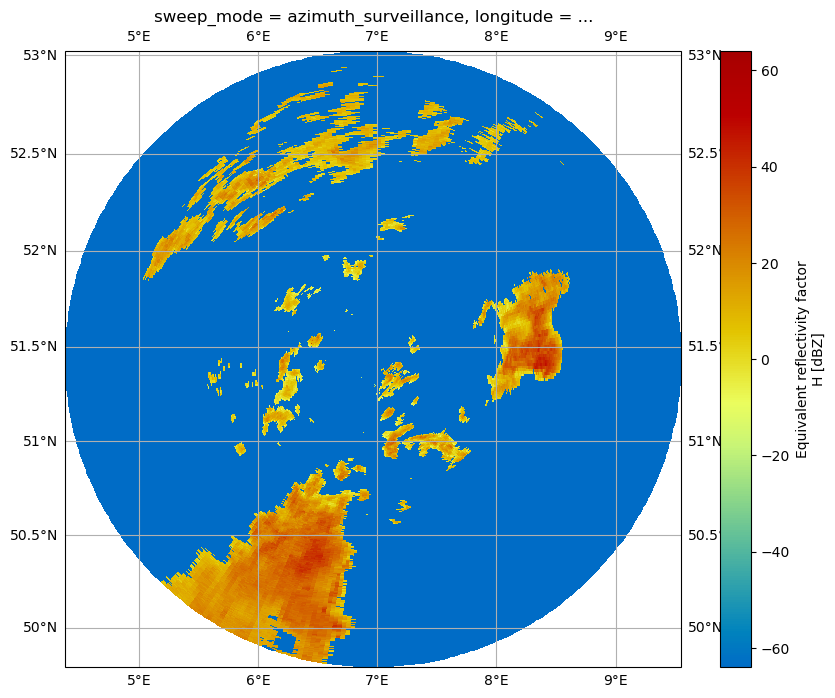

In [21]:
map_proj = ccrs.Mercator(central_longitude=vol0.root.ds.longitude.values)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=map_proj)
pm = swp.DBZH.wrl.georef.georeference().wrl.vis.plot(ax=ax)
ax.gridlines(draw_labels=True)

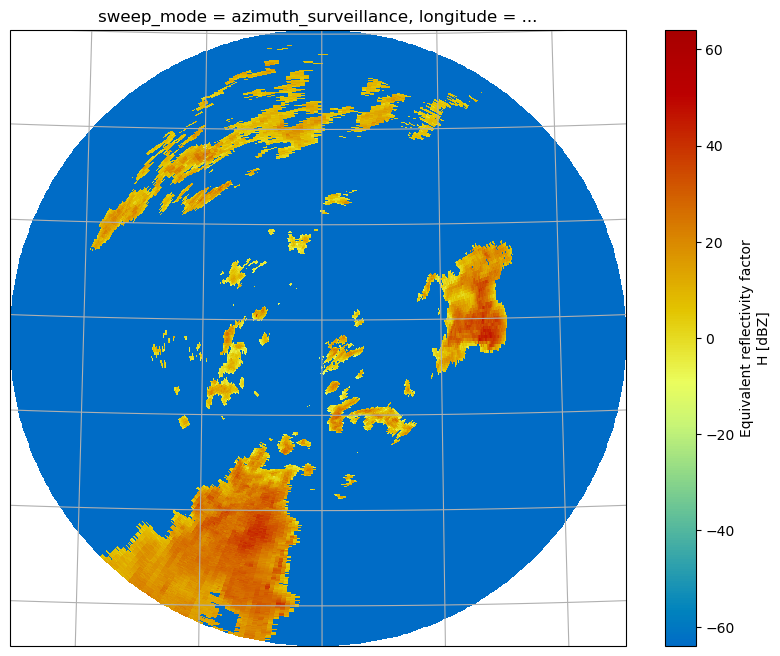

In [22]:
fig = plt.figure(figsize=(10, 8))
proj = ccrs.AzimuthalEquidistant(
    central_latitude=vol0.root.ds.latitude.values,
    central_longitude=vol0.root.ds.longitude.values,
)
ax = fig.add_subplot(111, projection=proj)
pm = swp.DBZH.wrl.georef.georeference().wrl.vis.plot(ax=ax)
ax.gridlines()

### Inspect radar moments

The DataArrays can be accessed by key or by attribute. Each DataArray inherits dimensions and coordinates of it's parent dataset. There are attributes connected which are defined by Cf/Radial and/or ODIM_H5 standard.

In [23]:
vol["sweep_9"].isel(volume_time=0).ds.DBZH

<xarray.DataArray 'DBZH' (azimuth: 360, range: 720)> Size: 2MB
array([[-64.00292982, -64.00292982, -64.00292982, ..., -64.00292982,
        -64.00292982, -64.00292982],
       [-64.00292982, -64.00292982, -64.00292982, ..., -64.00292982,
        -64.00292982, -64.00292982],
       [-64.00292982, -64.00292982, -64.00292982, ..., -64.00292982,
        -64.00292982, -64.00292982],
       ...,
       [-64.00292982, -64.00292982, -64.00292982, ..., -64.00292982,
        -64.00292982, -64.00292982],
       [-64.00292982, -64.00292982, -64.00292982, ..., -64.00292982,
        -64.00292982, -64.00292982],
       [-64.00292982, -64.00292982, -64.00292982, ..., -64.00292982,
        -64.00292982, -64.00292982]])
Coordinates:
  * range        (range) float32 3kB 125.0 375.0 625.0 ... 1.796e+05 1.799e+05
  * azimuth      (azimuth) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    elevation    (azimuth) float64 3kB 1.494 1.494 1.494 ... 1.494 1.494 1.494
    time         (azimuth) datetime64[ns] 3kB 2024-08-30T08:07:24.474999808 ....
    longitude    float64 8B 6.967
    latitude     float64 8B 51.41
    altitude     float64 8B 185.1
    volume_time  datetime64[ns] 8B 2024-08-30T08:07:30.775000064
Attributes:
    _Undetect:      0.0
    standard_name:  radar_equivalent_reflectivity_factor_h
    long_name:      Equivalent reflectivity factor H
    units:          dBZ

In [24]:
vol["sweep_9"].isel(volume_time=0).ds.sweep_mode

<xarray.DataArray 'sweep_mode' ()> Size: 80B
array('azimuth_surveillance', dtype='<U20')
Coordinates:
    longitude    float64 8B 6.967
    latitude     float64 8B 51.41
    altitude     float64 8B 185.1
    volume_time  datetime64[ns] 8B 2024-08-30T08:07:30.775000064

## Plot Quasi Vertical Profile

In [25]:
ts = vol["sweep_9"]
ts

DataTree('sweep_9', parent="root")
    Dimensions:            (volume_time: 24, azimuth: 360, range: 720)
    Coordinates:
      * range              (range) float32 3kB 125.0 375.0 ... 1.796e+05 1.799e+05
      * azimuth            (azimuth) float64 3kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
        elevation          (volume_time, azimuth) float64 69kB 1.494 1.494 ... 1.494
        time               (volume_time, azimuth) datetime64[ns] 69kB 2024-08-30T...
        longitude          float64 8B 6.967
        latitude           float64 8B 51.41
        altitude           float64 8B 185.1
      * volume_time        (volume_time) datetime64[ns] 192B 2024-08-30T08:07:30....
    Data variables:
        DBZH               (volume_time, azimuth, range) float64 50MB -64.0 ... -...
        sweep_mode         (volume_time) <U20 2kB 'azimuth_surveillance' ... 'azi...
        sweep_number       int64 8B 9
        prt_mode           (volume_time) <U7 672B 'not_set' 'not_set' ... 'not_set'
        follow_mode        (volume_time) <U7 672B 'not_set' 'not_set' ... 'not_set'
        sweep_fixed_angle  (volume_time) float64 192B 1.5 1.5 1.5 ... 1.5 1.5 1.5
        VRADH              (volume_time, azimuth, range) float64 50MB -128.0 ... ...

(0.0, 20000.0)

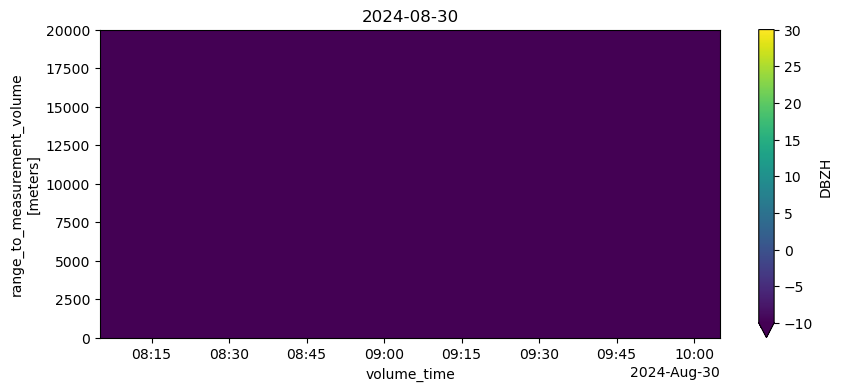

In [26]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
ts.ds.DBZH.median("azimuth").plot(x="volume_time", vmin=-10, vmax=30, ax=ax)
ax.set_title(f"{np.datetime_as_string(ts.ds.time[0][0].values, unit='D')}")
ax.set_ylim(0, 20000)

## Export to OdimH5

This exports the radar volume at given timestep including all moments into one ODIM_H5 compliant data file.

In [27]:
xradar.io.to_odim(vol0, "dwd_odim.h5", source="RAD:DWD")

## Export to Cf/Radial2

This exports the radar volume at given timestep including all moments into one Cf/Radial2 compliant data file.

In [28]:
xradar.io.to_cfradial2(vol0, "dwd_cfradial2.nc")

## Import again


In [29]:
vol1 = xradar.io.open_odim_datatree("dwd_odim.h5")
display(vol1)

DataTree('root', parent=None)
│   Dimensions:              ()
│   Data variables:
│       volume_number        int64 8B 0
│       platform_type        <U5 20B 'fixed'
│       instrument_type      <U5 20B 'radar'
│       time_coverage_start  <U20 80B '2024-08-30T08:05:35Z'
│       time_coverage_end    <U20 80B '2024-08-30T08:09:02Z'
│       longitude            float64 8B 6.967
│       altitude             float64 8B 185.1
│       latitude             float64 8B 51.41
│   Attributes:
│       Conventions:      ODIM_H5/V2_2
│       instrument_name:  None
│       version:          None
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None
│       comment:          im/exported using xradar
├── DataTree('sweep_0')
│       Dimensions:            (azimuth: 360, range: 720)
│       Coordinates:
│           elevation          (azimuth) float64 3kB ...
│           time               (azimuth) datetime64[ns] 3kB 2024-08-30T08:07:52.79164...
│         * range              (range) float32 3kB 125.0 375.0 ... 1.796e+05 1.799e+05
│           longitude          float64 8B ...
│           latitude           float64 8B ...
│           altitude           float64 8B ...
│         * azimuth            (azimuth) float32 1kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
│       Data variables:
│           DBZH               (azimuth, range) float64 2MB ...
│           VRADH              (azimuth, range) float64 2MB ...
│           sweep_mode         <U20 80B ...
│           sweep_number       int64 8B ...
│           prt_mode           <U7 28B ...
│           follow_mode        <U7 28B ...
│           sweep_fixed_angle  float64 8B ...
├── DataTree('sweep_1')
│       Dimensions:            (azimuth: 360, range: 496)
│       Coordinates:
│           elevation          (azimuth) float64 3kB ...
│           time               (azimuth) datetime64[ns] 3kB 2024-08-30T08:08:15.08333...
│         * range              (range) float32 2kB 125.0 375.0 ... 1.236e+05 1.239e+05
│           longitude          float64 8B ...
│           latitude           float64 8B ...
│           altitude           float64 8B ...
│         * azimuth            (azimuth) float32 1kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
│       Data variables:
│           DBZH               (azimuth, range) float64 1MB ...
│           VRADH              (azimuth, range) float64 1MB ...
│           sweep_mode         <U20 80B ...
│           sweep_number       int64 8B ...
│           prt_mode           <U7 28B ...
│           follow_mode        <U7 28B ...
│           sweep_fixed_angle  float64 8B ...
├── DataTree('sweep_2')
│       Dimensions:            (azimuth: 360, range: 240)
│       Coordinates:
│           elevation          (azimuth) float64 3kB ...
│           time               (azimuth) datetime64[ns] 3kB 2024-08-30T08:08:30.68332...
│         * range              (range) float32 960B 125.0 375.0 ... 5.962e+04 5.988e+04
│           longitude          float64 8B ...
│           latitude           float64 8B ...
│           altitude           float64 8B ...
│         * azimuth            (azimuth) float32 1kB 0.5 1.5 2.5 ... 357.5 358.5 359.5
│       Data variables:
│           DBZH               (azimuth, range) float64 691kB ...
│           VRADH              (azimuth, range) float64 691kB ...
│           sweep_mode         <U20 80B ...
│           sweep_number       int64 8B ...
│           prt_mode           <U7 28B ...
│           follow_mode        <U7 28B ...
│           sweep_fixed_angle  float64 8B ...
├── DataTree('sweep_3')
│       Dimensions:            (azimuth: 360, range: 240)
│       Coordinates:
│           elevation          (azimuth) float64 3kB ...
│           time               (azimuth) datetime64[ns] 3kB 2024-08-30T08:08:42.44999...
│         * range              (range) float32 960B 125.0 375.0 ... 5.962e+04 5.988e+04
│           longitude          float64 8B ...
│           latitu

In [30]:
vol2 = open_datatree("dwd_cfradial2.nc")
display(vol2)

DataTree('None', parent=None)
│   Dimensions:              ()
│   Coordinates:
│       longitude            float64 8B ...
│       altitude             float64 8B ...
│       latitude             float64 8B ...
│       volume_time          datetime64[ns] 8B ...
│   Data variables:
│       volume_number        int64 8B ...
│       platform_type        <U5 20B ...
│       instrument_type      <U5 20B ...
│       time_coverage_start  <U20 80B ...
│       time_coverage_end    <U20 80B ...
│   Attributes:
│       Conventions:      Cf/Radial
│       instrument_name:  None
│       version:          2.0
│       title:            None
│       institution:      None
│       references:       None
│       source:           None
│       history:          None: xradar v0.6.4 CfRadial2 export
│       comment:          im/exported using xradar
├── DataTree('sweep_0')
│       Dimensions:            (time: 360, range: 720)
│       Coordinates:
│         * range              (range) float32 3kB 125.0 375.0 ... 1.796e+05 1.799e+05
│           azimuth            (time) float64 3kB ...
│           elevation          (time) float64 3kB ...
│         * time               (time) datetime64[ns] 3kB 2024-08-30T08:07:30.77500006...
│       Data variables:
│           DBZH               (time, range) float64 2MB ...
│           sweep_mode         <U20 80B ...
│           sweep_number       int64 8B ...
│           prt_mode           <U7 28B ...
│           follow_mode        <U7 28B ...
│           sweep_fixed_angle  float64 8B ...
│           VRADH              (time, range) float64 2MB ...
├── DataTree('sweep_1')
│       Dimensions:            (time: 360, range: 496)
│       Coordinates:
│         * range              (range) float32 2kB 125.0 375.0 ... 1.236e+05 1.239e+05
│           azimuth            (time) float64 3kB ...
│           elevation          (time) float64 3kB ...
│         * time               (time) datetime64[ns] 3kB 2024-08-30T08:08:02.35900006...
│       Data variables:
│           DBZH               (time, range) float64 1MB ...
│           sweep_mode         <U20 80B ...
│           sweep_number       int64 8B ...
│           prt_mode           <U7 28B ...
│           follow_mode        <U7 28B ...
│           sweep_fixed_angle  float64 8B ...
│           VRADH              (time, range) float64 1MB ...
├── DataTree('sweep_2')
│       Dimensions:            (time: 360, range: 240)
│       Coordinates:
│         * range              (range) float32 960B 125.0 375.0 ... 5.962e+04 5.988e+04
│           azimuth            (time) float64 3kB ...
│           elevation          (time) float64 3kB ...
│         * time               (time) datetime64[ns] 3kB 2024-08-30T08:08:23.76999987...
│       Data variables:
│           DBZH               (time, range) float64 691kB ...
│           sweep_mode         <U20 80B ...
│           sweep_number       int64 8B ...
│           prt_mode           <U7 28B ...
│           follow_mode        <U7 28B ...
│           sweep_fixed_angle  float64 8B ...
│           VRADH              (time, range) float64 691kB ...
├── DataTree('sweep_3')
│       Dimensions:            (time: 360, range: 240)
│       Coordinates:
│         * range              (range) float32 960B 125.0 375.0 ... 5.962e+04 5.988e+04
│           azimuth            (time) float64 3kB ...
│           elevation          (time) float64 3kB ...
│         * time               (time) datetime64[ns] 3kB 2024-08-30T08:08:37.00449996...
│       Data variables:
│           DBZH               (time, range) float64 691kB ...
│           sweep_mode         <U20 80B ...
│           sweep_number       int64 8B ...
│           prt_mode           <U7 28B ...
│           follow_mode        <U7 28B ...
│           sweep_fixed_angle  float64 8B ...
│           VRADH              (time, range) float64 691kB ...
├── DataTree('sweep_4')
│       Dimensions:            (time: 360, range: 240)
│       Coordinates:
│         * range              (range) float32 96